In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import time
import warnings
warnings.filterwarnings('ignore')

### Importing Data (and timing how long it takes)

In [3]:
s=time.time()
df = pd.read_csv('lending-club-loan-data/df_clean.csv')
e=time.time()
print('Readtime: {}'.format(e-s))

Readtime: 9.217854976654053


In [5]:
df.drop(columns=['Unnamed: 0'], inplace=True)

## Summary Statistics:

In [6]:
summary = pd.DataFrame(df.describe().T)
summary

,count,mean,std,min,25%,50%,75%,max
loan_amnt,917472.0,15355.510332,9611.962770,1000.00,8000.00,13000.000,20000.00,40000.00
int_rate,917472.0,13.161842,5.131936,5.31,9.44,12.620,15.99,30.99
installment,917472.0,455.019910,280.167487,7.61,250.55,380.365,610.23,1719.83
annual_inc,917472.0,83880.542018,85180.202055,20.00,50000.00,70000.000,100000.00,10999200.00
loan_status,917472.0,0.080627,0.272262,0.00,0.00,0.000,0.00,1.00
...,...,...,...,...,...,...,...,...
tax_liens,917472.0,0.047789,0.378982,0.00,0.00,0.000,0.00,61.00
tot_hi_cred_lim,917472.0,196748.448431,186857.634381,1100.00,61128.00,134900.000,282721.00,9999999.00
total_bal_ex_mort,917472.0,58665.392242,53411.663797,1.00,26109.00,43808.000,73159.00,3408095.00
total_bc_limit,917472.0,24712.509687,23854.349464,100.00,9100.00,17600.000,32300.00,1105500.00


## Identifying all columns datatypes

In [8]:
df.dtypes.value_counts()

float64    63
object     14
int64       3
dtype: int64

In [8]:
#creating a list of all columns from the original df
df_cols = list(df.columns)

#creating an indexed list for all columns in the df by datatype (this step is needed for the loop I'm going to write):
dtypes_enum = enumerate(df.dtypes)

#writing a loop to extract the index positions of the object columns:
obj_index_list = []
for i,j in list(dtypes_enum):
    if j == object:
        obj_index_list.append(i)


#With the list of index positions, we can extract the object columns from the df:        
object_columns = [df_cols[col] for col in obj_index_list]
df_obj = df[object_columns]    

In [48]:
#Extracting all the numeric columns:
df_num = df.select_dtypes(include='number')
numeric_columns = list(df_num.columns)

# Univariate EDA

## Exploring the data within the object columns:

In [10]:
#Creating a list of object columns with more than 51 unique values
object_columns_big = []
for i in object_columns:
    if df[i].nunique() > 51:
        object_columns_big.append(i)

In [11]:
#Creating a list of object columns with less that 51 unique values
for i in object_columns_big:
    object_columns.remove(i)

In [12]:
split_points = list(range(3,13,3))
split_obj_cols = [object_columns[i : j] for i, j in zip([0] + split_points, split_points + [None])] 

### Frequency Distributions of Object columns (<51 unique values)

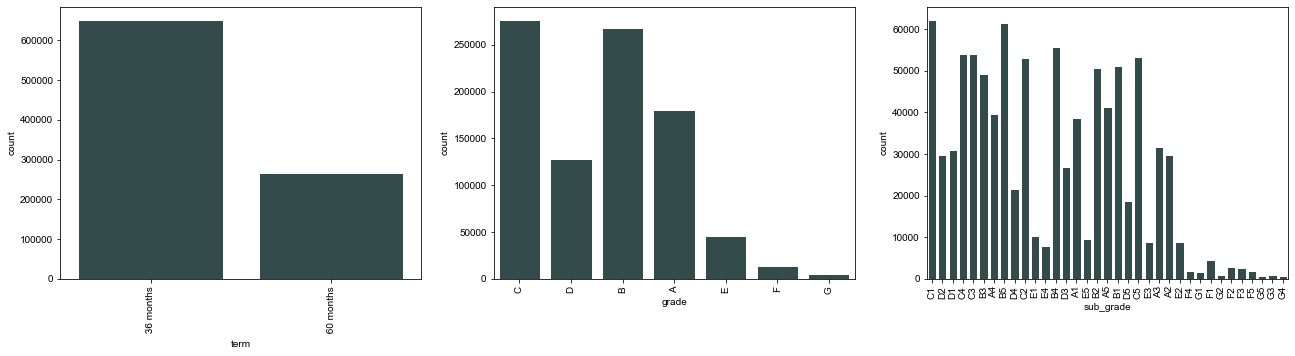

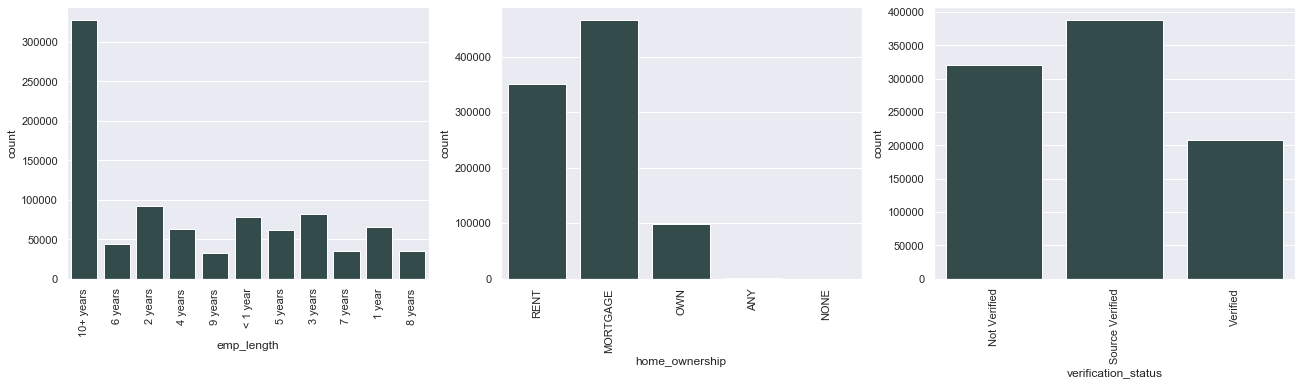

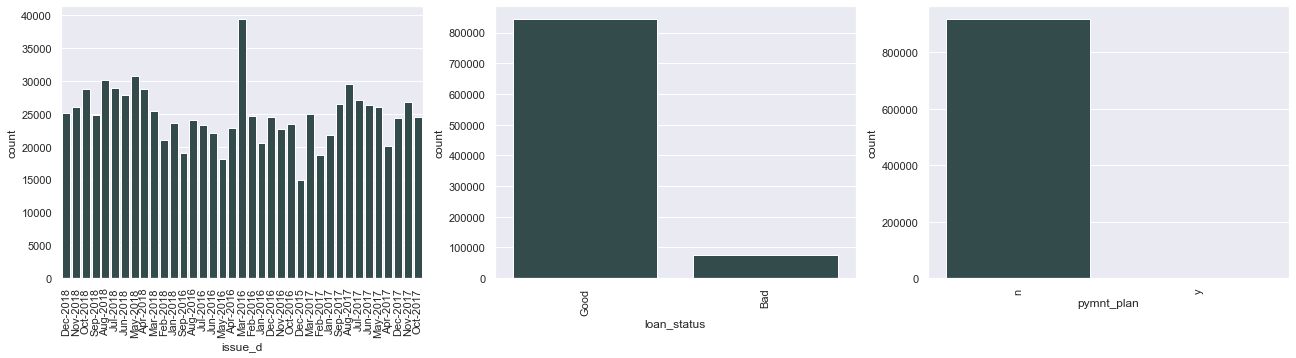

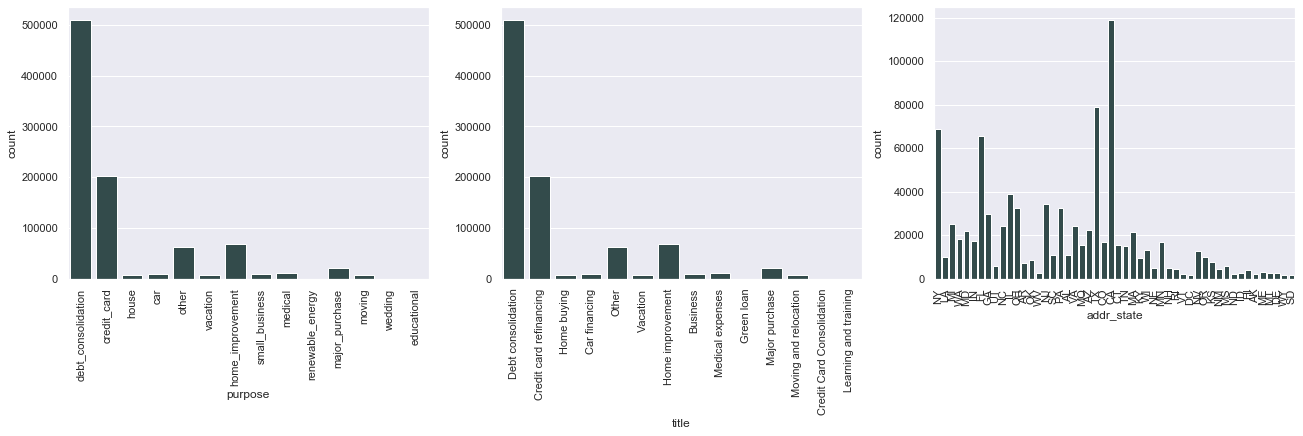

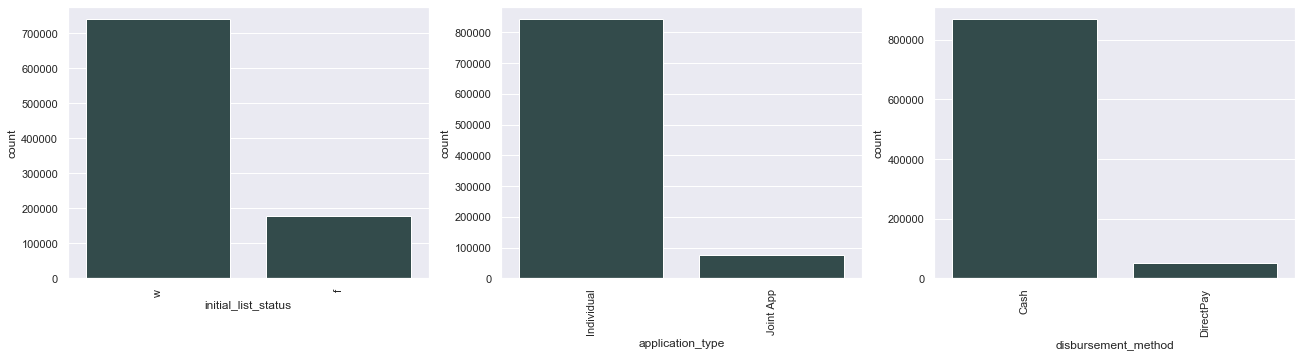

In [13]:
for i in split_obj_cols:
    fig, axes = plt.subplots(ncols=len(i), figsize=(22,5))
    for ax, col in zip(axes, i):
        sns.set(style='darkgrid')
        sns.countplot(df[col], ax=ax, color='darkslategray')
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
    plt.show()

In [14]:
df['emp_title'] = df['emp_title'].apply(lambda x: x.lower())
freq_etitle = pd.DataFrame(df['emp_title'].value_counts())
freq_etitle.rename(columns={0:'emp_title'})
freq_etitle = freq_etitle.loc[freq_etitle.emp_title > 1000]

In [15]:
df['earliest_cr_line'] = df['earliest_cr_line'].apply(lambda x: x.lower())
freq_ecr = pd.DataFrame(df['earliest_cr_line'].value_counts())
freq_ecr.rename(columns={0:'earliest_cr_line'})
hifreq_ecr = freq_ecr.loc[freq_ecr.earliest_cr_line > 3000]

### Frequency Distributions of Object Columns (>51 unique values)

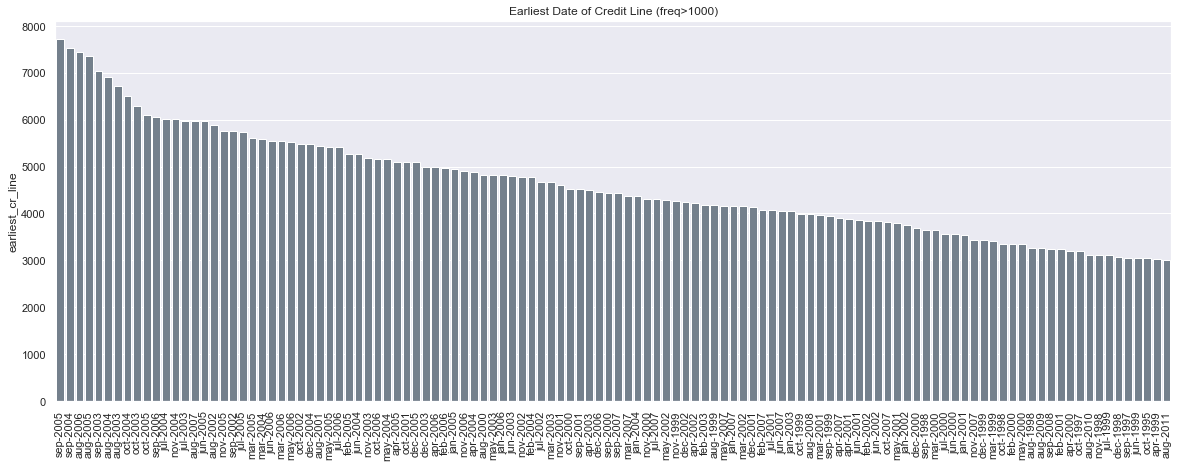

In [16]:
sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(x = hifreq_ecr.index, y=hifreq_ecr.earliest_cr_line, color='slategray', order=hifreq_ecr.index)
plt.xticks(rotation=90)
plt.title('Earliest Date of Credit Line (freq>1000)')
plt.show()

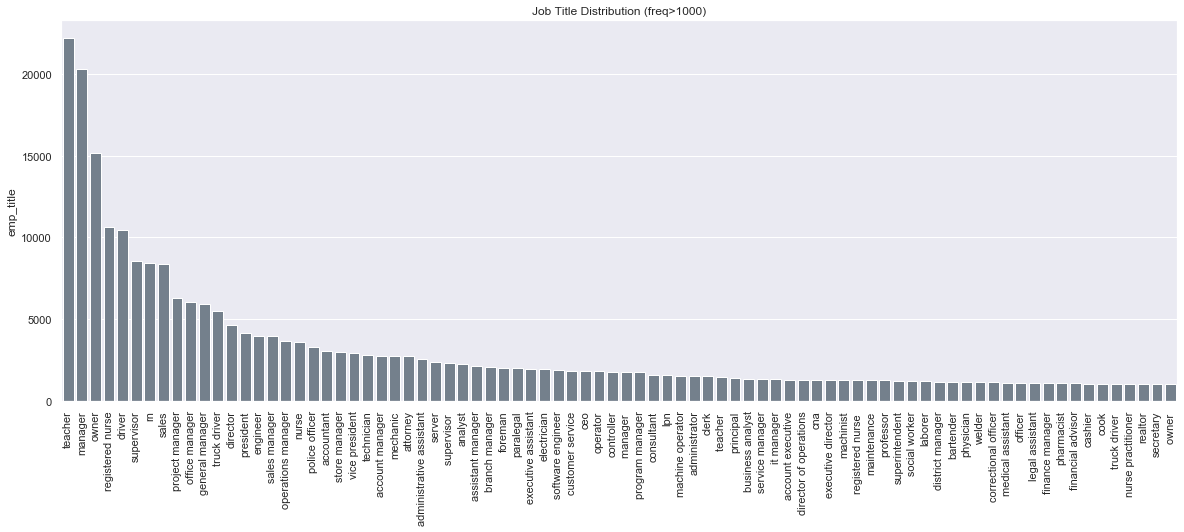

In [17]:
job_freq = pd.DataFrame(df['emp_title'].value_counts())
most_freq = job_freq.loc[job_freq['emp_title'] > 1000]
sns.set(rc={'figure.figsize':(20,7)})
sns.barplot(x = most_freq.index, y=most_freq.emp_title, color='slategray', order=most_freq.index)
plt.xticks(rotation=90)
plt.title('Job Title Distribution (freq>1000)')
plt.show()

## Exploring the data within the numeric columns:

In [49]:
split_points = list(range(4,65,4))
split_num_cols = [numeric_columns[i : j] for i, j in zip([0] + split_points, split_points + [None])] 

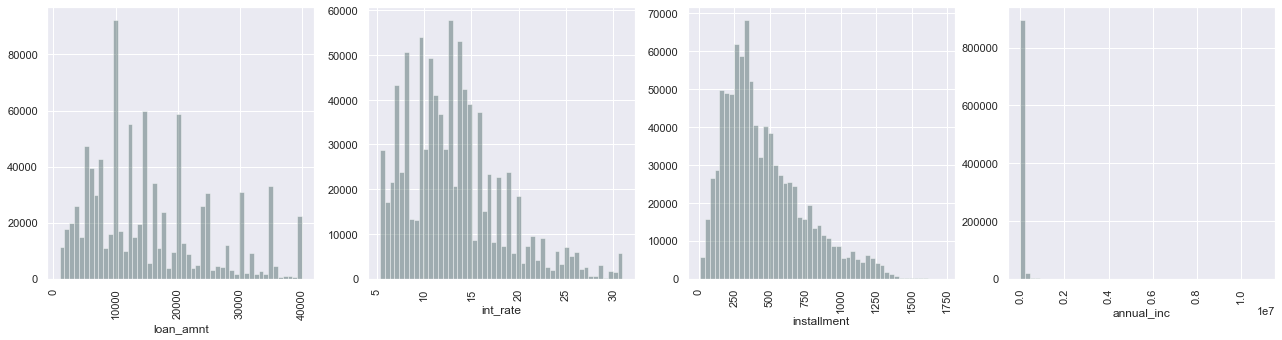

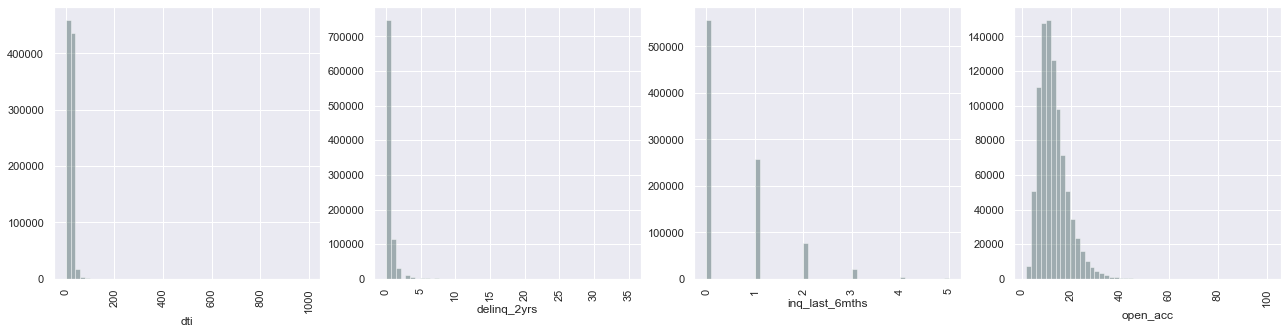

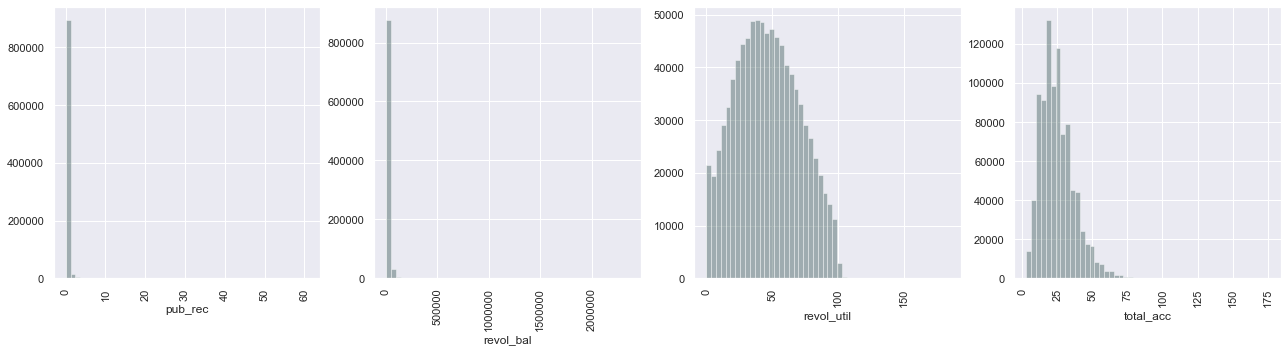

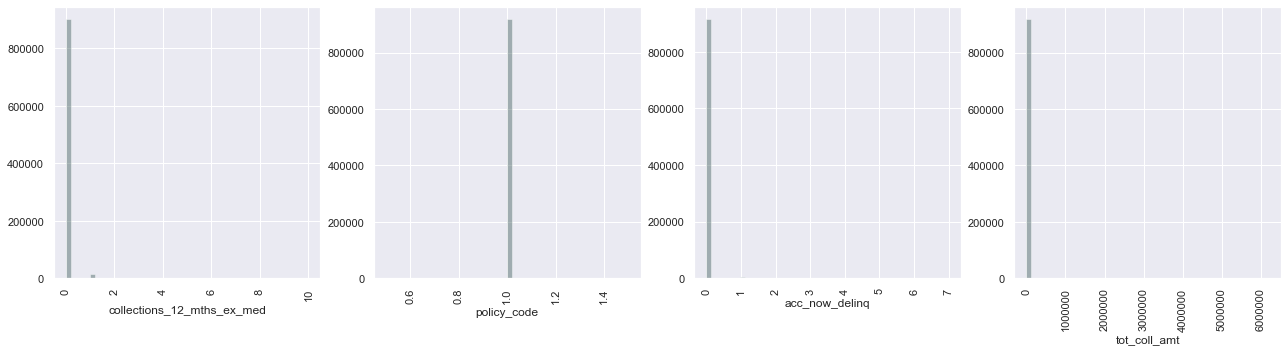

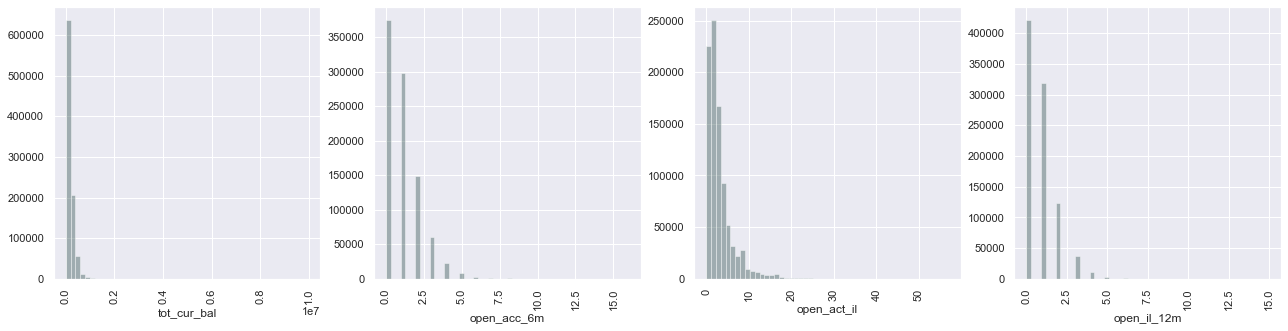

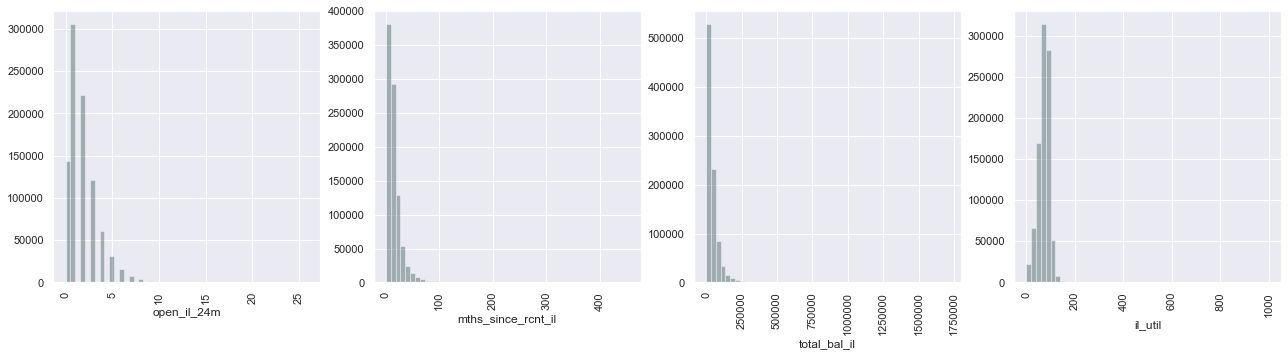

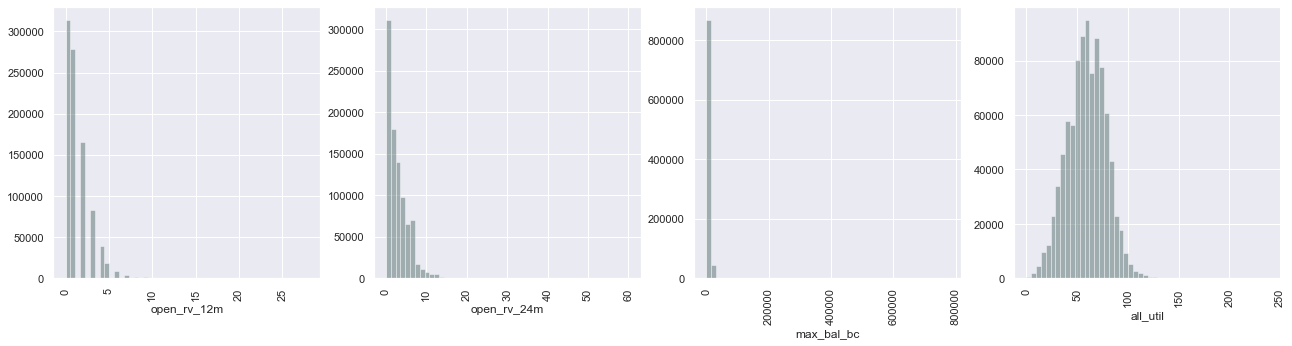

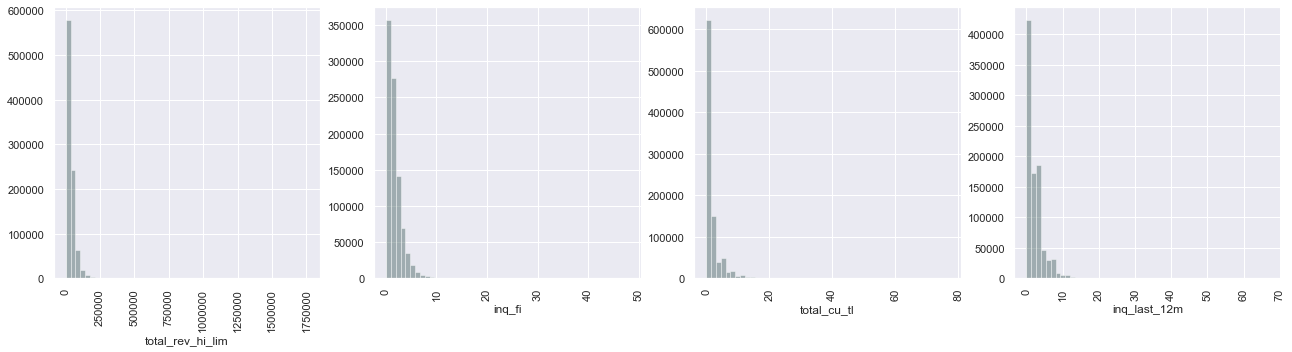

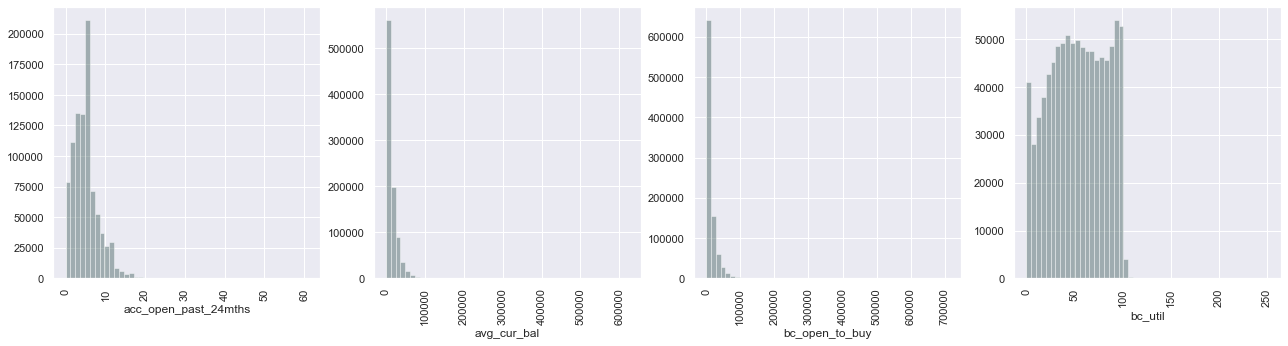

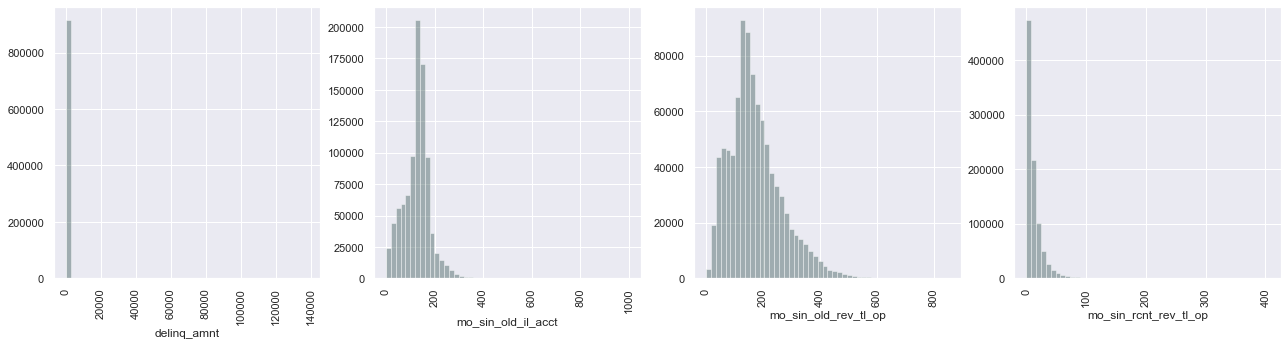

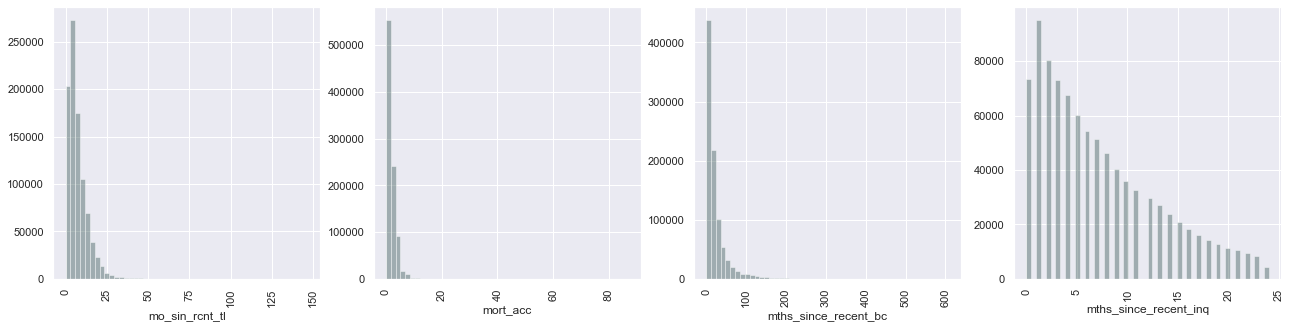

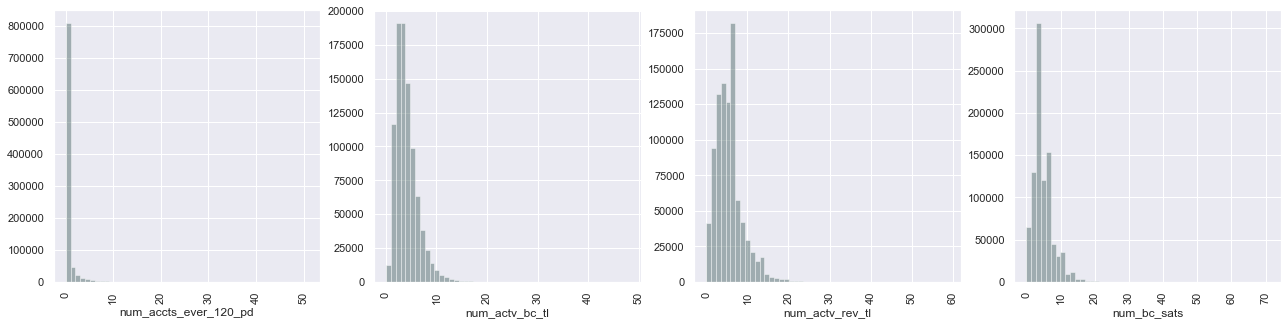

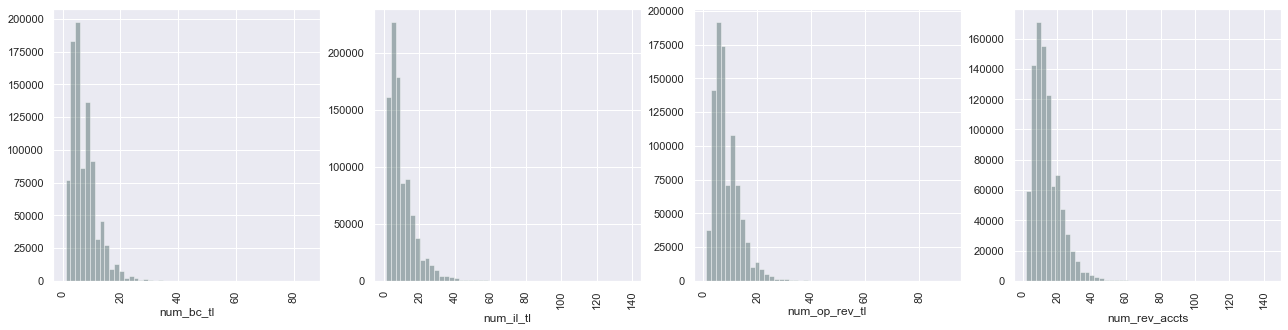

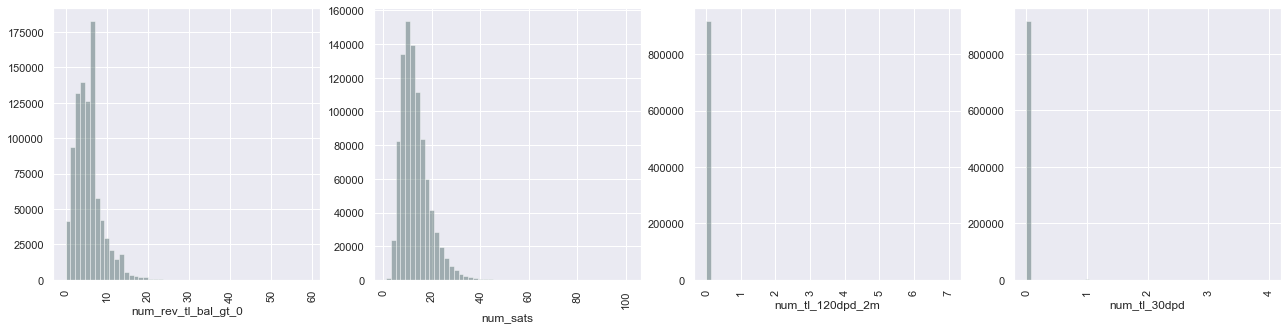

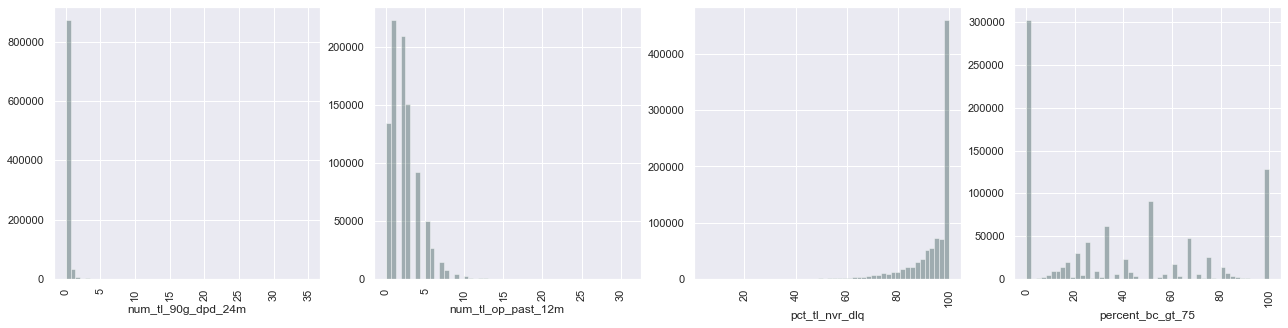

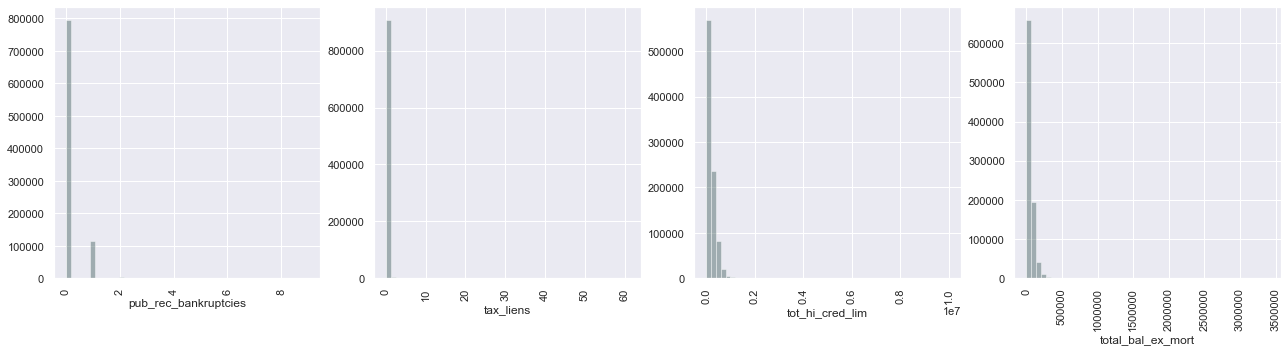

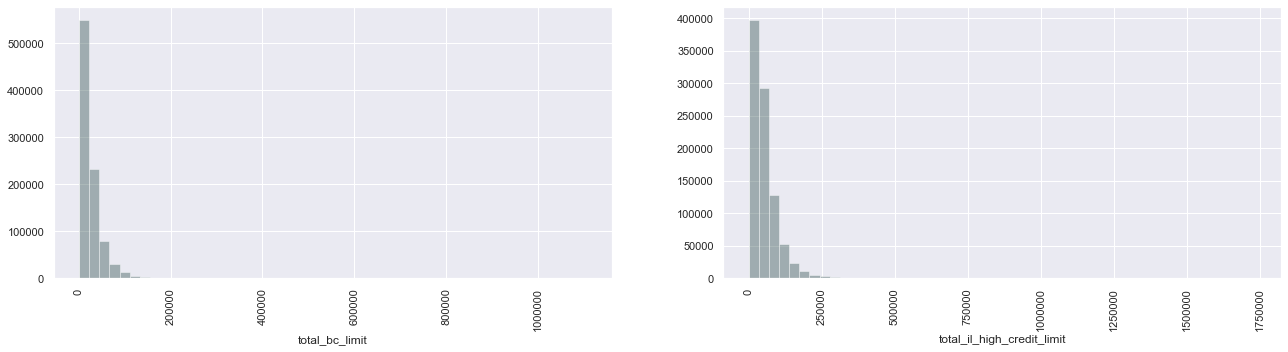

In [50]:
for i in split_num_cols:
    fig, axes = plt.subplots(ncols=len(i), figsize=(22,5))
    for ax, col in zip(axes, i):
        sns.set(style='darkgrid')
        sns.distplot(df[col], ax=ax, color='darkslategray', kde=False)
        for ax in fig.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
    plt.show()

# Bivariate Analysis

### Correlation between columns:

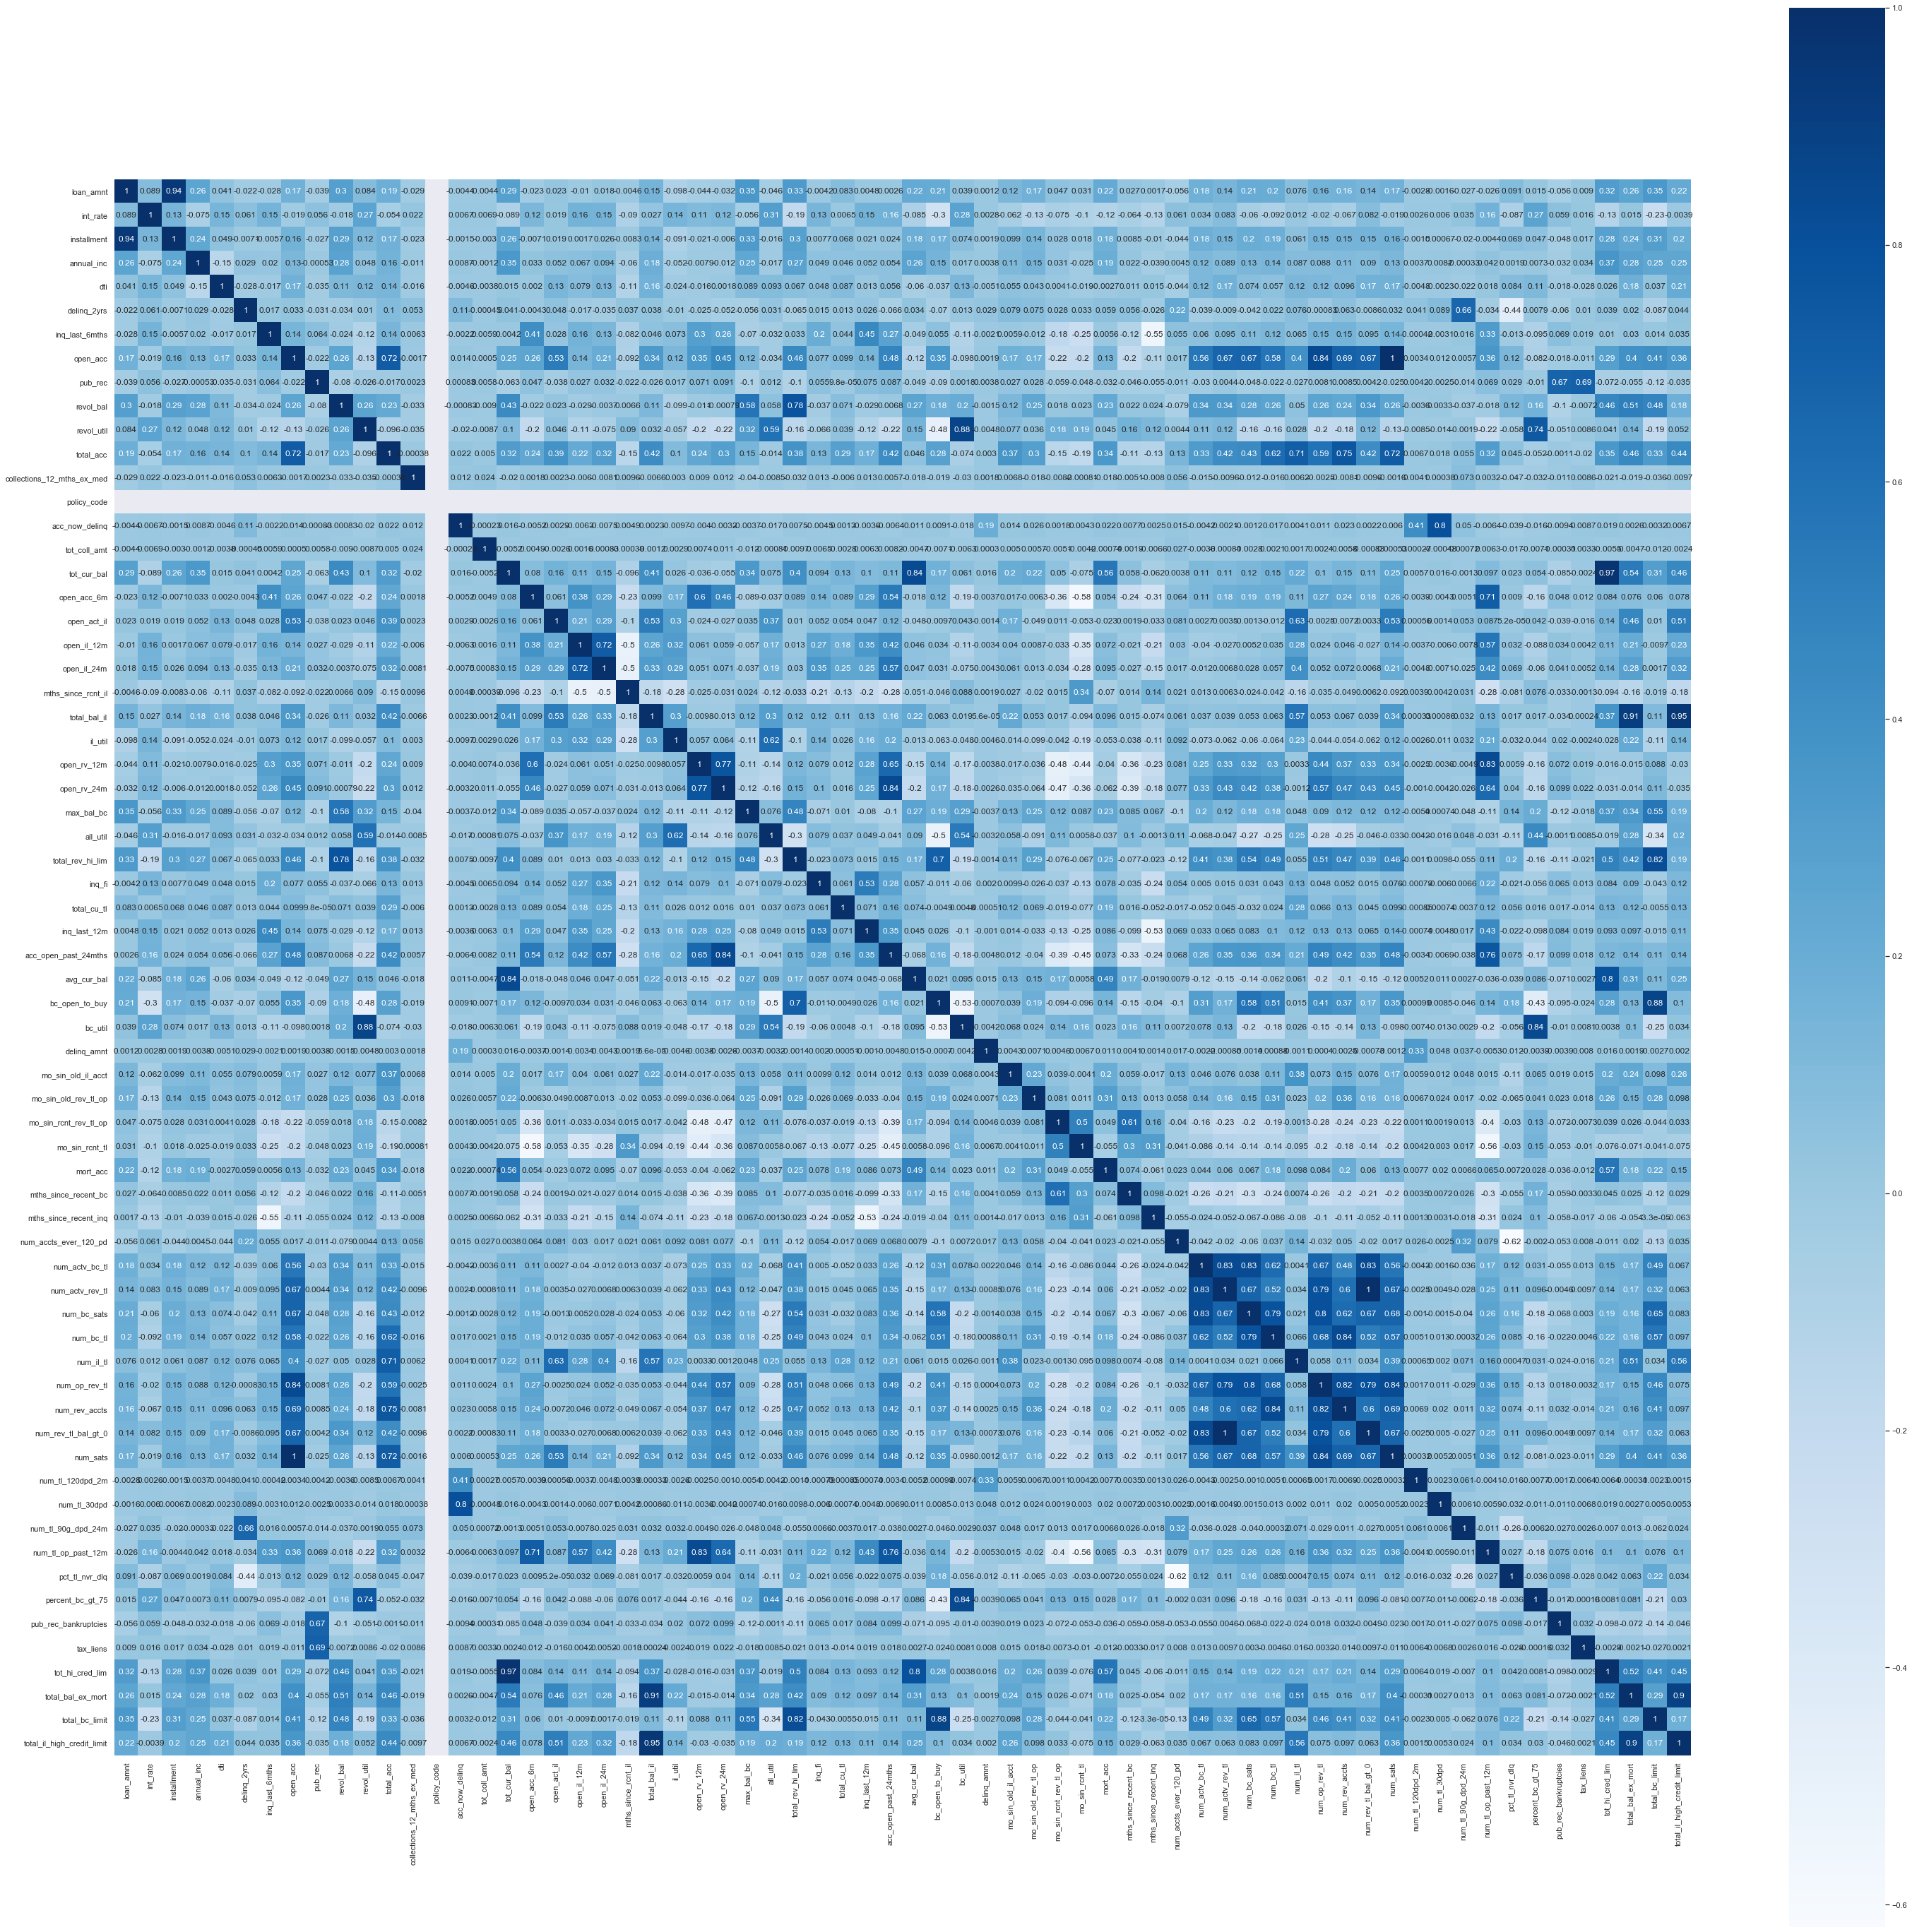

In [20]:
plt.figure(figsize=(50,50))
sns.heatmap(df_num.corr(),cmap='Blues',annot=True,square=True)
plt.show()

In [5]:
df['loan_status'].replace(to_replace='Good', value=0, inplace=True)
df['loan_status'].replace(to_replace='Bad', value=1, inplace=True)

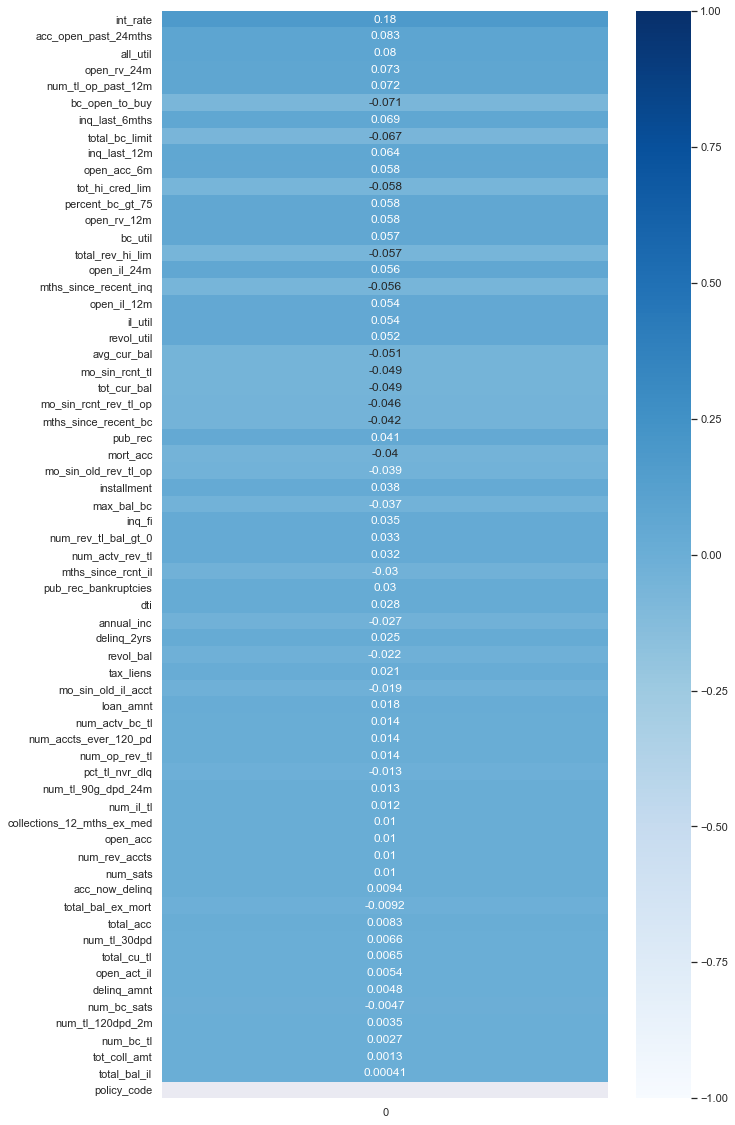

In [22]:
correlations = df_num.corrwith(df['loan_status']).iloc[:-1].to_frame()
correlations['abs'] = correlations[0].abs()
sorted_correlations = correlations.sort_values('abs', ascending=False)[0]
fig, ax = plt.subplots(figsize=(10,20))
sns.heatmap(sorted_correlations.to_frame(), cmap='Blues', annot=True, vmin=-1, vmax=1, ax=ax);

In [11]:
# for i in split_obj_cols:
#     fig, axes = plt.subplots(ncols=len(i), figsize=(30,5))
#     for ax, col in zip(axes, i):
#         sns.set()
#         sns.boxplot(x=df[col], y=df['loan_status'], ax=ax, color='rebeccapurple')
#         for ax in fig.axes:
#             plt.sca(ax)
#             plt.xticks(rotation=90)
#     plt.show()

In [7]:
df.to_csv('lending-club-loan-data/df_clean.csv')